# Modellierung der erwarteten Schadenhöhe pro Versicherungsnehmer und Jahr

## Ziel
Die Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden.

## Vorgehensweise

### 1. Explorative Datenanalyse
Machen Sie sich mit dem Datensatz vertraut. Identifizieren Sie dabei mögliche Probleme sowie grundlegende statistische Zusammenhänge, welche für die anschließende Modellierung wichtig sein könnten.

### 2. Feature Engineering
Bereiten Sie, soweit für ihre Modellierung nötig, die Variablen geeignet auf.

### 3. Modellvergleich
Entscheiden Sie sich für ein geeignetes Modell anhand einer dafür geeigneten Metrik. Erläutern Sie wie Sie dabei vorgehen und begründen Sie ihre Entscheidung.

### 4. Modellbuilding
Trainieren Sie unter Berücksichtigung der vorangegangenen Schritte das von Ihnen gewählte Modell zur Vorhersage der erwarteten Schadenhöhe pro Kunde und Jahr. Ihr Ziel ist es, einen möglichst fairen Versicherungsbeitrag pro Jahr für einzelne Kunden anhand der Ihnen zur Verfügung stehenden Merkmale zu bestimmen. Wählen Sie mindestens eine geeignete Metrik, um die Güte des finalen Modells zu beurteilen. Zeigen Sie, welche Variablen und Zusammenhänge für Ihr finales Modell relevant sind. Überlegen Sie sich (ohne dies umzusetzen), wie Sie Ihr Modell weiter optimieren könnten.

## Datensatz

### freMTPL2freq
- **IDpol**: ID des Vertrags
- **ClaimNb**: Anzahl Schäden im Versicherungszeitraum
- **Exposure**: Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen Variable]
- **Area**: Area-Code des Versicherungsnehmers [unabhängige Variable]
- **VehPower**: Leistung des versicherten Kfz [unabhängige Variable]
- **VehAge**: Alter des versicherten Kfz [unabhängige Variable]
- **DrivAge**: Alter des Versicherungsnehmers [unabhängige Variable]
- **BonusMalus**: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable]
- **VehBrand**: Marke des versicherten Kfz [unabhängige Variable]
- **VehGas**: Antrieb des versicherten Kfz [unabhängige Variable]
- **Density**: Anzahl der Einwohner pro km² im Wohnort des Versicherungsnehmers [unabhängige Variable]
- **Region**: Region des Versicherungsnehmers [unabhängige Variable]

### freMTPL2sev
- **IDpol**: ID des Vertrags
- **ClaimAmount**: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable. Die abhängige Variable ist definiert als ClaimAmount / Exposure]


In [ ]:
!pip install arff

## 0. Data Preprocessing

In [3]:
import pandas as pd
import arff

data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq , columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"] )
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])
df_sev_agg = df_sev.groupby('IDpol', as_index=False).sum()

In [4]:
df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [5]:
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


### 0.1 Remove Outlier and Create Features

In [32]:
# Create Features of Interest
df = pd.merge(df_freq, df_sev_agg, on='IDpol', how='left')
df['ClaimFreq'] = df['ClaimNb'] / df['Exposure']
df['ClaimSev'] = df['ClaimAmount']/ df['ClaimNb']
df['AnnualClaimAmount'] = df['ClaimAmount'] / df['Exposure']

# Drop Duplicates with Id in
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")
df = df.drop_duplicates()

#Outlier Removal Quantile
def remove_outlier(data: pd.DataFrame, column: str) -> list[pd.DataFrame, int, int]:
    Q1 = data[column][data[column] > 0].quantile(0.25)
    Q3 = data[column][data[column] > 0].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (data[column] >= lower_bound) & (data[column] <= upper_bound) | data[column].isna()
    removed = len(data[column])-sum(mask)
    print(f"{column}: LowerBound: {lower_bound:.2f} UpperBound: {upper_bound:.2f} Removed: {removed}")
    return data[mask], lower_bound, upper_bound


df_o, a, b = remove_outlier(df, 'ClaimSev')
df_o, a, b = remove_outlier(df_o, 'ClaimFreq')
df_o = df_o.drop(columns=["IDpol"])

# Clip High Vehicle Ages
df_o['VehAge'] = df_o['VehAge'].clip(upper=50)



Number of duplicate rows: 0
ClaimSev: LowerBound: -65.73 UpperBound: 2004.37 Removed: 3635
ClaimFreq: LowerBound: -2.19 UpperBound: 6.31 Removed: 4095


## 1. Descriptive Analysis

In [33]:
df_o.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimFreq,ClaimSev,AnnualClaimAmount
1,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN,1.298701,NaN,NaN
2,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',NaN,1.333333,NaN,NaN
4,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN,1.190476,NaN,NaN
5,1.0,0.52,'E',6.0,2.0,38.0,50.0,'B12',Regular,3003.0,'R31',NaN,1.923077,NaN,NaN
6,1.0,0.45,'E',6.0,2.0,38.0,50.0,'B12',Regular,3003.0,'R31',NaN,2.222222,NaN,NaN


In [34]:
df_o.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimFreq,ClaimSev,AnnualClaimAmount
count,670283.000000,670283.000000,670283.000000,670283.000000,670283.000000,670283.000000,670283.000000,19887.000000,670283.000000,19887.000000,19887.000000
mean,0.041187,0.531066,6.454699,7.059936,45.514966,59.705214,1787.704000,989.305756,0.071403,940.051655,1646.993766
std,0.208447,0.363999,2.050475,5.613010,14.133515,15.579884,3952.219535,529.769347,0.423444,447.837514,1405.888159
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,91.000000,602.000000,0.000000,602.000000,880.978571
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,390.000000,1128.120000,0.000000,1128.120000,1204.000000
75%,0.000000,1.000000,7.000000,11.000000,55.000000,64.000000,1629.000000,1204.000000,0.000000,1204.000000,2040.677966
max,5.000000,2.010000,15.000000,50.000000,100.000000,230.000000,27000.000000,6918.100000,6.250000,2004.200000,11864.696970


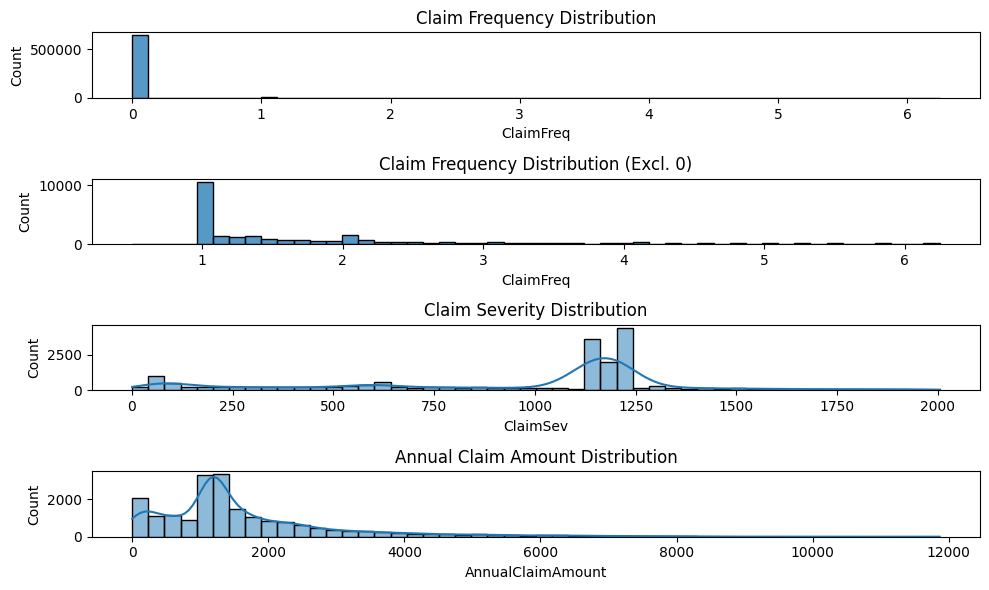

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

#columns = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimAmount', 'ClaimFreq', 'ClaimSev']
plt.figure(figsize=(10, 6))

# Creating the subplot figure
plt.subplot(4, 1, 1)
sns.histplot(df_o['ClaimFreq'], kde=False, bins=50)
plt.title('Claim Frequency Distribution')

plt.subplot(4, 1, 2)
sns.histplot(df_o['ClaimFreq'][df_o['ClaimFreq'] > 0], kde=False, bins=50)
plt.title('Claim Frequency Distribution (Excl. 0)')

plt.subplot(4, 1, 3)
sns.histplot(df_o['ClaimSev'], kde=True, bins=50)
plt.title('Claim Severity Distribution')

plt.subplot(4, 1, 4)
sns.histplot(df_o['AnnualClaimAmount'], kde=True, bins=50)
plt.title('Annual Claim Amount Distribution')

plt.tight_layout()
plt.show()


## 2. Feature Analysis

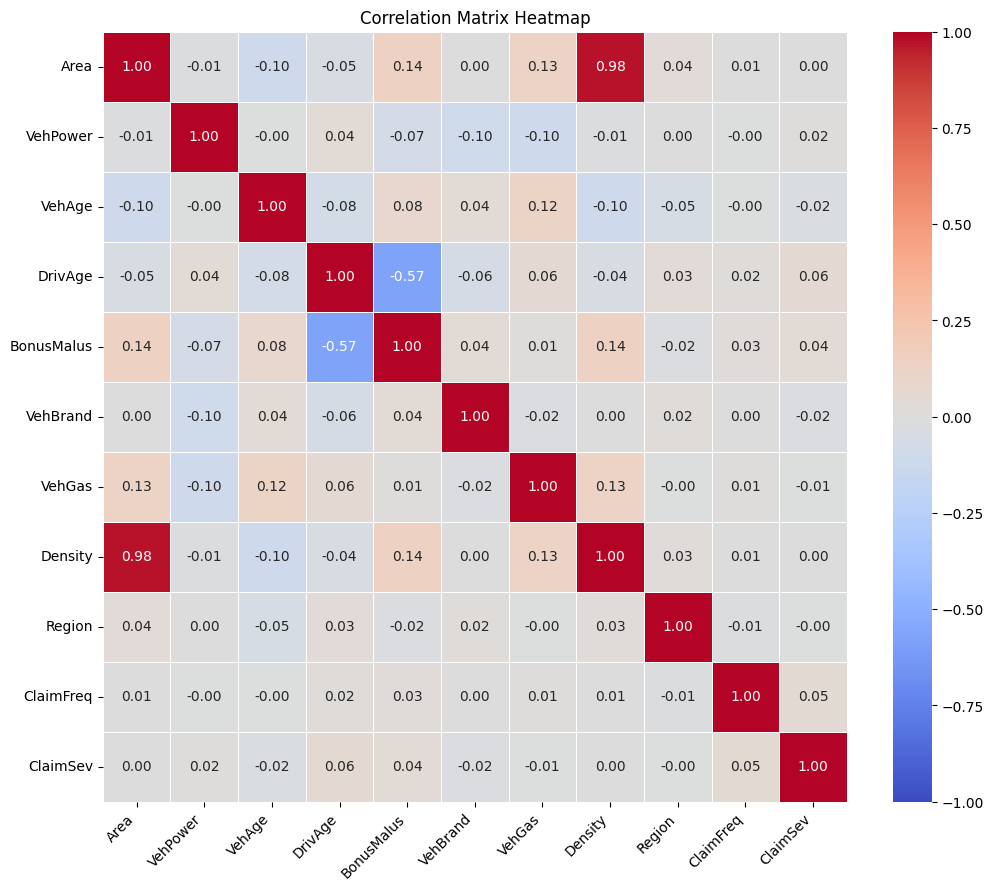

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

df_encoded = df_o.copy()
df_encoded['Area'] = df_encoded['Area'].astype('category').cat.codes
df_encoded['VehBrand'] = df_encoded['VehBrand'].astype('category').cat.codes
df_encoded['VehGas'] = df_encoded['VehGas'].astype('category').cat.codes
df_encoded['Region'] = df_encoded['Region'].astype('category').cat.codes

# Calculating correlation matrix
df_encoded = df_encoded.drop(columns=['ClaimNb', 'Exposure', 'AnnualClaimAmount', 'ClaimAmount'])
correlation_matrix = df_encoded.corr(method='spearman')

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

### 2.2 Response Variable-Predictor Visualization

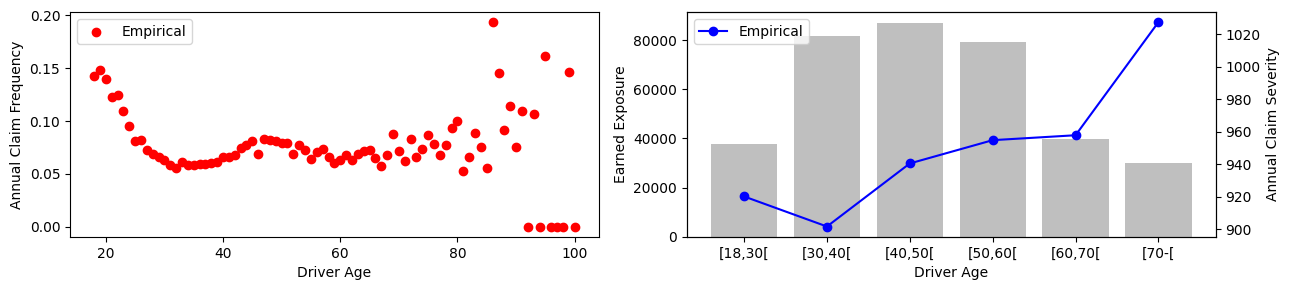

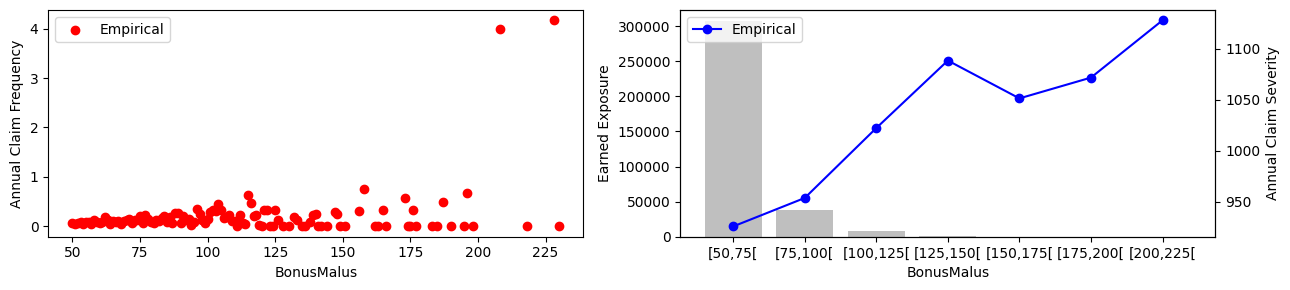

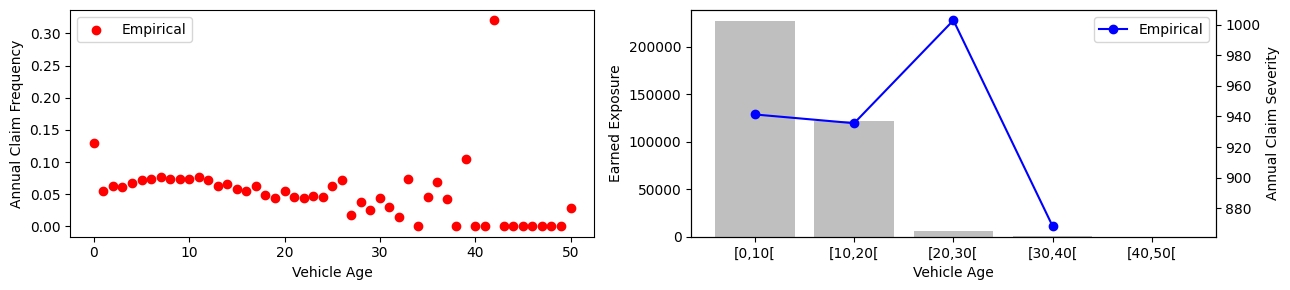

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_and_plot(freq_df, sev_df, group_col, bins, labels, xlabel,
                       plot_predicted=False, pred_claim_freq_col=None, pred_claim_sev_col=None):
    freq_df_copy = freq_df.copy()
    sev_df_copy = sev_df.copy()

    # Calculate the mean claim frequency and average cost for each group
    mean_claim_freq = freq_df_copy.groupby(group_col)['ClaimFreq'].mean().reset_index()
    mean_avg_cost = sev_df_copy.groupby(group_col)['ClaimSev'].mean().reset_index()

    if plot_predicted:
        # Calculate the mean predicted values for each group
        mean_pred_claim_freq = freq_df_copy.groupby(group_col)[pred_claim_freq_col].mean().reset_index()
        mean_pred_avg_cost = sev_df_copy.groupby(group_col)[pred_claim_sev_col].mean().reset_index()

    # Calculate the aggregated data for the binned groups
    freq_df_copy[f'{group_col}Group'] = pd.cut(freq_df_copy[group_col], bins=bins, labels=labels, right=False)
    sev_df_copy[f'{group_col}Group'] = pd.cut(sev_df_copy[group_col], bins=bins, labels=labels, right=False)

    agg_data_freq = freq_df_copy.groupby(f'{group_col}Group').agg(
        EmpiricalClaimFreq=('ClaimFreq', 'mean'),
        Exposure=('Exposure', 'sum')
    ).reset_index()

    agg_data_sev = sev_df_copy.groupby(f'{group_col}Group').agg(
        EmpiricalAvgCost=('ClaimSev', 'mean'),
        Exposure=('Exposure', 'sum')
    ).reset_index()

    #agg_data = pd.merge(agg_data_freq, agg_data_sev, on=f'{group_col}Group')

    if plot_predicted:
        agg_data_freq['PredictedClaimFreq'] = freq_df_copy.groupby(f'{group_col}Group')[pred_claim_freq_col].mean().values
        agg_data_sev['PredictedAvgCost'] = sev_df_copy.groupby(f'{group_col}Group')[pred_claim_sev_col].mean().values
    # Plot the figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 3))

    # Top left plot: Empirical (and Predicted if plot_predicted=True) Annual Claim Frequency vs. Group (Mean for each group)
    axes[0].scatter(mean_claim_freq[group_col], mean_claim_freq['ClaimFreq'], color='red', label='Empirical')
    if plot_predicted:
        axes[0].scatter(mean_pred_claim_freq[group_col], mean_pred_claim_freq[pred_claim_freq_col], color='pink', label='Predicted')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Annual Claim Frequency')
    axes[0].legend()

    # Top right plot: Empirical (and Predicted if plot_predicted=True) Annual Claim Frequency by Group
    axes[1].bar(agg_data_sev[f'{group_col}Group'], agg_data_sev['Exposure'], color='grey', alpha=0.5)
    axes[1].set_ylabel('Earned Exposure')
    axes[1].set_xlabel(xlabel)
    axes2 = axes[1].twinx()
    axes2.errorbar(agg_data_sev[f'{group_col}Group'], agg_data_sev['EmpiricalAvgCost'], color='blue', marker='o', linestyle='-', label='Empirical')
    if plot_predicted:
        #axes2.errorbar(sev_df_copy["ClaimSev"], sev_df_copy[pred_claim_sev_col], color='blue', marker='x', linestyle='--', label='Predicted')
        axes2.errorbar(agg_data_sev[f'{group_col}Group'], agg_data_sev['PredictedAvgCost'], color='green', marker='x', linestyle='--', label='Predicted')
    axes2.set_ylabel('Annual Claim Severity')
    axes2.legend()
    #print(agg_data_sev)
    plt.tight_layout()
    plt.show()

# Assuming df is the original dataframe you provided
df_copy = df_o.copy()

# Create separate dataframes for frequency and severity
freq_df = df_copy[['DrivAge', 'BonusMalus', 'VehAge', 'ClaimFreq', 'Exposure']].copy()
sev_df = df_copy[['DrivAge', 'BonusMalus', 'VehAge', 'ClaimSev', 'Exposure']].copy()

groups = [
    {'group_col': 'DrivAge', 'bins': [18, 30, 40, 50, 60, 70, 100], 'labels': ['[18,30[', '[30,40[', '[40,50[', '[50,60[', '[60,70[', '[70-['], 'xlabel': 'Driver Age'},
    {'group_col': 'BonusMalus', 'bins': [50, 75, 100, 125, 150, 175, 200, 225], 'labels': ['[50,75[', '[75,100[', '[100,125[', '[125,150[', '[150,175[', '[175,200[', '[200,225['], 'xlabel': 'BonusMalus'},
    {'group_col': 'VehAge', 'bins': [0, 10, 20, 30, 40, 50], 'labels': ['[0,10[', '[10,20[', '[20,30[', '[30,40[', '[40,50['], 'xlabel': 'Vehicle Age'}
]
for group in groups:
    calculate_and_plot(freq_df, sev_df, group['group_col'], group['bins'], group['labels'], group['xlabel'])


## 3. Modeling

### 3.1 Helper Functions

In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.genmod.families import Poisson, NegativeBinomial, Tweedie, Gamma
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def fit_and_evaluate_glm(model_family, X_train, y_train, exposure_train, X_test, y_test, exposure_test):
    model = sm.GLM(y_train, X_train, family=model_family, var_weights=exposure_train)
    results = model.fit()

    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    metrics = {
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_mse": train_mse,
        "test_mse": test_mse
    }

    return results, metrics, test_predictions

def fit_and_evaluate_zip(X_train, y_train, exposure_train, X_test, y_test, exposure_test):
    model = ZeroInflatedPoisson(y_train, X_train, exposure=exposure_train)
    results = model.fit(maxiter=150)

    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    metrics = {
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_mse": train_mse,
        "test_mse": test_mse
    }

    return results, metrics, test_predictions

def fit_and_evaluate_rf(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=69)
    model.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    metrics = {
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_mse": train_mse,
        "test_mse": test_mse
    }

    return model, metrics, test_predictions

### 3.2 Dataset Creation

In [38]:
# Preprocessing and data set preparation
model_data = df_o.copy()

# Encode Categorical Variables with 1 Hot
categorical_columns = ['Area', 'VehBrand', 'VehGas', 'Region']
model_data = pd.get_dummies(model_data, columns=categorical_columns, drop_first=True)
model_data.columns = model_data.columns.str.replace("'", "", regex=True)
model_data.columns = model_data.columns.str.replace(" ", "_", regex=True)

# Bin Integer Numerical Values
model_data["VehAge"] = pd.cut(model_data["VehAge"], bins=10, labels=False)
model_data["DrivAge"] = pd.cut(model_data["DrivAge"], bins=10, labels=False)
model_data["BonusMalus"] = pd.cut(model_data["BonusMalus"], bins=10, labels=False)

model_data["ClaimFreq"] = model_data["ClaimFreq"].astype(float)  # Ensure target is float
model_data["Exposure"] = model_data["Exposure"].astype(float)    # Ensure weights are float if needed

X = model_data.copy().drop(columns=['ClaimSev', 'ClaimFreq', 'ClaimAmount', 'AnnualClaimAmount', 'ClaimNb', 'Exposure', 'Density'])
X = X.astype(int)
train_data, test_data, X_train, X_test = train_test_split(model_data, X, test_size=0.2, random_state=69)

# Prepare data for ClaimFreq modeling
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
y_train_freq = np.asarray(train_data["ClaimFreq"])
y_test_freq = np.asarray(test_data["ClaimFreq"])
exposure_train = np.asarray(train_data["Exposure"])
exposure_test = np.asarray(test_data["Exposure"])

# Prepare data for ClaimSev modeling
train_mask = (train_data['ClaimSev'] > 0) & (~train_data['ClaimSev'].isna())
test_mask = (test_data['ClaimSev'] > 0) & (~test_data['ClaimSev'].isna())
X_train_sev = sm.add_constant(X_train[train_mask])
X_test_sev = sm.add_constant(X_test[test_mask])
y_train_sev = np.asarray(train_data[train_mask]["ClaimSev"])
y_test_sev = np.asarray(test_data[test_mask]["ClaimSev"])
exposure_train_sev = np.asarray(train_data[train_mask]["Exposure"])
exposure_test_sev = np.asarray(test_data[test_mask]["Exposure"])

In [39]:
X_train

,const,VehPower,VehAge,DrivAge,BonusMalus,Area_B,Area_C,Area_D,Area_E,Area_F,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
621829,1.0,4,0,2,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
22728,1.0,7,0,2,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
602167,1.0,6,0,7,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
476543,1.0,7,0,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
397123,1.0,6,1,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447134,1.0,6,0,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
556327,1.0,7,1,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
672882,1.0,9,1,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
525570,1.0,7,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Claim Frequency Modeling

In [14]:
# Model families for ClaimFreq
model_families = {
    "Poisson": Poisson(),
    "Negative Binomial": NegativeBinomial(alpha=1.0),
    "Tweedie": Tweedie(var_power=1.5)
}

# Fit GLM models for ClaimFreq and store results
models = {}
predictions = {}
results_summary = {}
metrics_summary = {}

for name, family in tqdm(model_families.items()):
    results, metrics, predictions = fit_and_evaluate_glm(family, X_train, y_train_freq, exposure_train, X_test, y_test_freq, exposure_test)
    models[name] = results
    predictions[name] = predictions
    results_summary[name] = results.summary()
    metrics_summary[name] = metrics

# Fit ZIP model for ClaimFreq and store results
zip_results, zip_metrics, pred = fit_and_evaluate_zip(X_train, y_train_freq, exposure_train, X_test, y_test_freq, exposure_test)
results_summary["Zero-Inflated Poisson"] = zip_results.summary()
metrics_summary["Zero-Inflated Poisson"] = zip_metrics

# Fit Random Forest model for ClaimFreq and store results
rf_model_freq, rf_metrics_freq, rf_prediction = fit_and_evaluate_rf(X_train, y_train_freq, X_test, y_test_freq)
metrics_summary["Random Forest"] = rf_metrics_freq

In [15]:
# Display results for ClaimFreq
for name, summary in results_summary.items():
    print(f"Model: {name}\n")
    print(summary)
    print("\n")

# Create a DataFrame to display the metrics for ClaimFreq
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df.columns = ["Train MAE", "Test MAE", "Train MSE", "Test MSE"]

# Display the metrics DataFrame for ClaimFreq
print("Claim Frequency Metrics:")
print(metrics_df)

Model: Poisson

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               536226
Model:                            GLM   Df Residuals:                   536184
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -82748.
Date:                Wed, 22 May 2024   Deviance:                   1.3094e+05
Time:                        15:06:16   Pearson chi2:                 4.98e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005332
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9654   

- Poisson GLM: Balanced performance, better fit than Tweedie, and slightly lower deviance.
- Negative Binomial GLM: Best log-likelihood and deviance among GLMs.
- Tweedie GLM: Similar performance to Poisson but with higher deviance.
- Zero-Inflated Poisson: Highest pseudo R-squared, better for data with many zero counts, but not converged and higher MAE and MSE.
- Random Forest: Excellent training performance but poor generalization (high test MSE), indicating overfitting.

### 3.4 Claim Severity Modeling

In [15]:
# Model families for ClaimSev
sev_model_families = {
    "Poisson": Poisson(),
    "Normal": sm.families.Gaussian(),
    "Negative Binomial": NegativeBinomial(),
    "Gamma": Gamma()
}

# Fit GLM models for ClaimSev and store results
sev_models = {}
sev_predictions = {}
sev_results_summary = {}
sev_metrics_summary = {}

for name, family in tqdm(sev_model_families.items()):
    results, metrics, predictions = fit_and_evaluate_glm(family, X_train_sev, y_train_sev, exposure_train_sev, X_test_sev, y_test_sev, exposure_test_sev)
    sev_models[name] = results
    sev_predictions[name] = predictions
    sev_results_summary[name] = results.summary()
    sev_metrics_summary[name] = metrics

## Fit Random Forest model for ClaimSev and store results
rf_model_sev, rf_metrics_sev, rf_predictions = fit_and_evaluate_rf(X_train_sev, y_train_sev, X_test_sev, y_test_sev)
sev_metrics_summary["Random Forest"] = rf_metrics_sev

In [16]:
# Display results for ClaimSev
for name, summary in sev_results_summary.items():
    print(f"Model: {name}\n")
    print(summary)
    print("\n")

# Create a DataFrame to display the metrics for ClaimSev
sev_metrics_df = pd.DataFrame(sev_metrics_summary).T
sev_metrics_df.columns = ["Train MAE", "Test MAE", "Train MSE", "Test MSE"]

# Display the metrics DataFrame for ClaimSev
print("Claim Severity Metrics:")
print(sev_metrics_df)

Model: Poisson

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                15908
Model:                            GLM   Df Residuals:                    15866
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6787e+06
Date:                Thu, 23 May 2024   Deviance:                   3.2570e+06
Time:                        07:55:07   Pearson chi2:                 2.55e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9887
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7274   

- Poisson GLM: Best for explaining the variance (high pseudo R-squared), good general performance (MAE, MSE).
- Normal GLM: Slightly better MAE and MSE, but much lower pseudo R-squared.
- Negative Binomial GLM: Best log-likelihood and deviance, solid MAE\MSE performance.
- Gamma GLM: Similar to Negative Binomial but slightly worse overall.
- Random Forest: Excellent training performance but poor generalization (high test MSE), indicating overfitting.

### 3.5 Visualization of Results

In [ ]:
poisson_results, poisson_metrics, freq_predictions = fit_and_evaluate_glm(Poisson(), X_train, y_train_freq, exposure_train, X_test, y_test_freq, exposure_test)
nbm_results, nbm_metrics, sev_predictions = fit_and_evaluate_glm(sm.families.NegativeBinomial(), X_train_sev, y_train_sev, exposure_train_sev, X_test_sev, y_test_sev, exposure_test_sev)
#gaussian_results, gaussian_metrics, sev_predictions = fit_and_evaluate_glm(sm.families.Gaussian(), X_train_sev, y_train_sev, exposure_train_sev, X_test_sev, y_test_sev, exposure_test_sev)


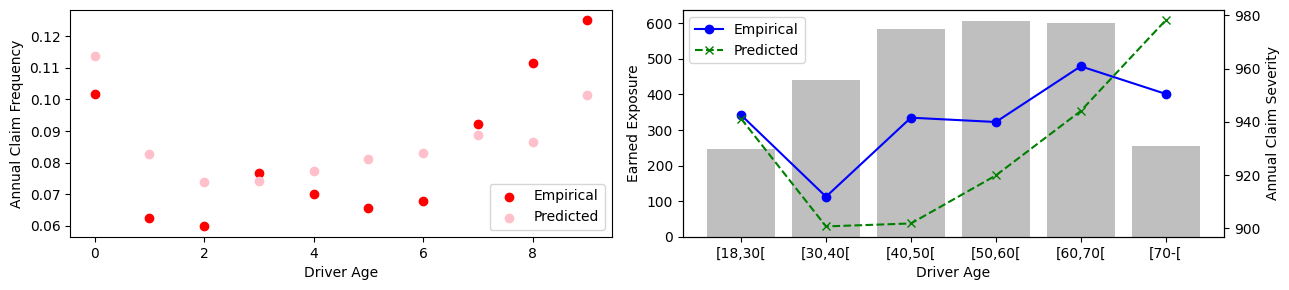

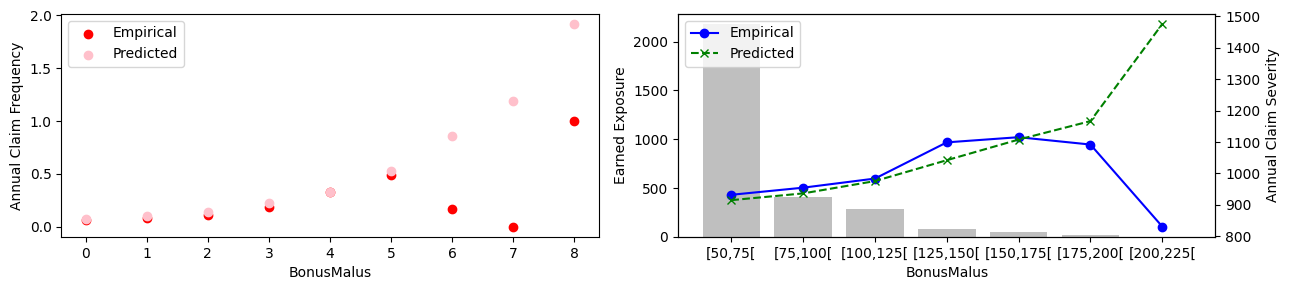

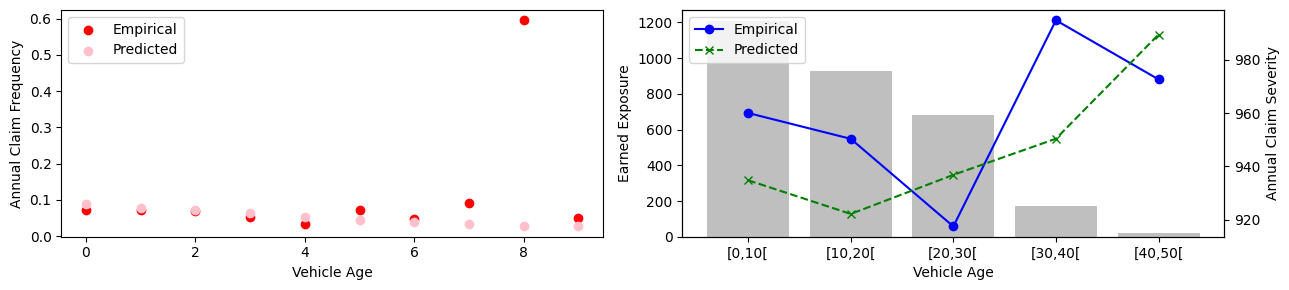

In [46]:
combined_freq_data = test_data.copy() #.drop(columns='const')
combined_sev_data = test_data.copy().dropna() #.drop(columns='const')

combined_freq_data['PredClaimFreq'] = freq_predictions
combined_sev_data['PredClaimSev'] = sev_predictions
#combined_sev_data = combined_sev_data.dropna()


groups = [
    {'group_col': 'DrivAge', 'bins': [0, 1, 2, 3, 4, 5, 6], 'labels': ['[18,30[', '[30,40[', '[40,50[', '[50,60[', '[60,70[', '[70-['], 'xlabel': 'Driver Age'},
    {'group_col': 'BonusMalus', 'bins': [0, 1, 2, 3, 4, 5, 6, 7], 'labels': ['[50,75[', '[75,100[', '[100,125[', '[125,150[', '[150,175[', '[175,200[', '[200,225['], 'xlabel': 'BonusMalus'},
    {'group_col': 'VehAge', 'bins': [0, 1, 2, 3, 4, 5], 'labels': ['[0,10[', '[10,20[', '[20,30[', '[30,40[', '[40,50['], 'xlabel': 'Vehicle Age'}
]
for group in groups:
    calculate_and_plot(combined_freq_data, combined_sev_data, group['group_col'], group['bins'], group['labels'], group['xlabel'],
                       plot_predicted=True, pred_claim_freq_col='PredClaimFreq', pred_claim_sev_col='PredClaimSev')


### 3.6 Combine Models for Modeling the Average Annual Claim Amount

In [47]:
test_data_amount = test_data.copy()
test_data_amount.loc[test_data_amount['ClaimNb'] == 0, 'AnnualClaimAmount'] = 0
test_data_amount = test_data_amount.dropna(subset=['AnnualClaimAmount'])
X_test_amount = X_test.copy()
X_test_amount = X_test_amount.loc[test_data_amount.index]

freq_predictions = poisson_results.predict(X_test_amount)
sev_predictions = nbm_results.predict(X_test_amount)
#sev_predictions = gaussian_results.predict(X_test_amount)

predicted_annual_amount = freq_predictions * sev_predictions
predicted_annual_amount.describe()

count    132798.000000
mean         76.116476
std          41.235379
min          19.629605
25%          55.081338
50%          67.026735
75%          83.955776
max        2721.732837
dtype: float64

### 3.7 Analysis of Combined Prediction

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# This is now only on the ones that already have a claim, we need all and if ClaimNb=0 fill NaN with 0
test_data_amount['PredClaimFreq'] = freq_predictions
test_data_amount['PredClaimSev'] = sev_predictions
test_data_amount['PredAnnualClaimAmount'] = predicted_annual_amount

mae = mean_absolute_error(test_data_amount['AnnualClaimAmount'], test_data_amount['PredAnnualClaimAmount'])
mse = mean_squared_error(test_data_amount['AnnualClaimAmount'], test_data_amount['PredAnnualClaimAmount'])
mean = (test_data_amount['AnnualClaimAmount'] - test_data_amount['PredAnnualClaimAmount']).mean()

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'Mean: {mean:.2f}')

MAE: 119.98
MSE: 138485.57
Mean: -26.91


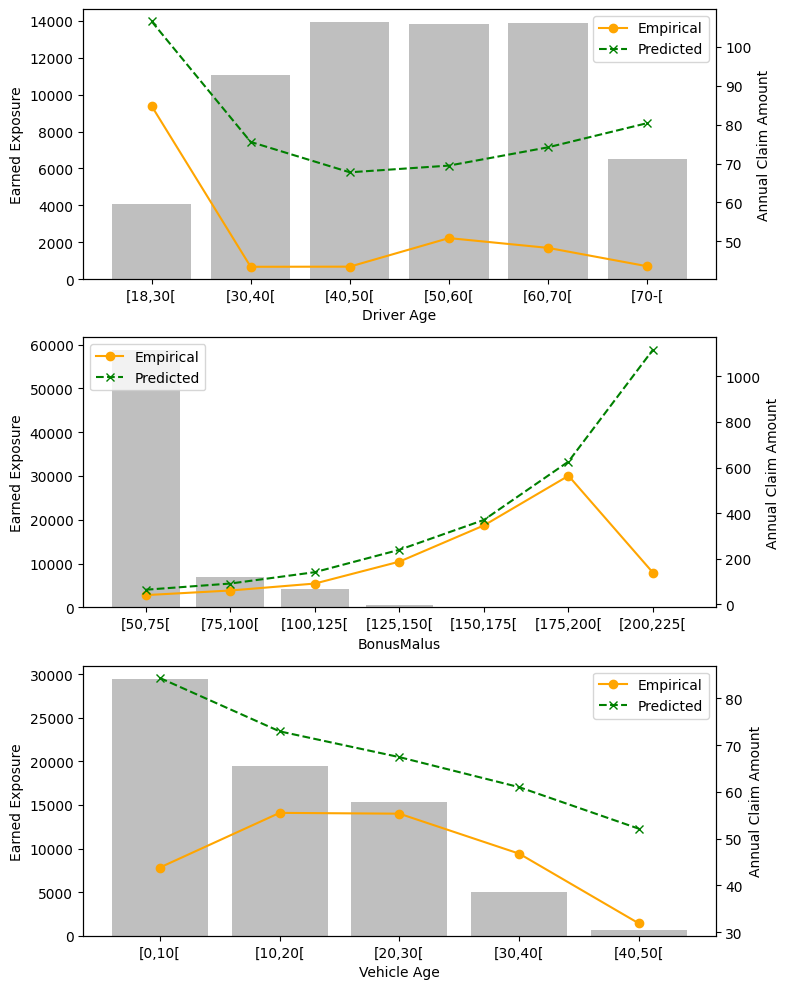

In [49]:

groups = [
    {'group_col': 'DrivAge', 'bins': [0, 1, 2, 3, 4, 5, 6], 'labels': ['[18,30[', '[30,40[', '[40,50[', '[50,60[', '[60,70[', '[70-['], 'xlabel': 'Driver Age'},
    {'group_col': 'BonusMalus', 'bins': [0, 1, 2, 3, 4, 5, 6, 7], 'labels': ['[50,75[', '[75,100[', '[100,125[', '[125,150[', '[150,175[', '[175,200[', '[200,225['], 'xlabel': 'BonusMalus'},
    {'group_col': 'VehAge', 'bins': [0, 1, 2, 3, 4, 5], 'labels': ['[0,10[', '[10,20[', '[20,30[', '[30,40[', '[40,50['], 'xlabel': 'Vehicle Age'}
]

fig, axes = plt.subplots(len(groups), 1, figsize=(8, 10))

for idx, group in enumerate(groups):
    group_col = group['group_col']
    bins = group['bins']
    labels = group['labels']
    xlabel = group['xlabel']

    test_data_amount[f'{group_col}Group'] = pd.cut(test_data_amount[group_col], bins=bins, labels=labels, right=False)

    agg_data_sev = test_data_amount.groupby(f'{group_col}Group').agg({
        'PredAnnualClaimAmount': 'mean',
        'AnnualClaimAmount': 'mean',
        'Exposure': 'sum'
    }).reset_index()

    agg_data_sev['EmpiricalAvgCost'] = agg_data_sev['AnnualClaimAmount'] #/ agg_data_sev['Exposure']
    agg_data_sev['PredictedAvgCost'] = agg_data_sev['PredAnnualClaimAmount'] #/ agg_data_sev['Exposure']

    ax1 = axes[idx]
    ax1.bar(agg_data_sev[f'{group_col}Group'], agg_data_sev['Exposure'], color='grey', alpha=0.5)
    ax1.set_ylabel('Earned Exposure')
    ax1.set_xlabel(xlabel)

    ax2 = ax1.twinx()
    ax2.errorbar(agg_data_sev[f'{group_col}Group'], agg_data_sev['EmpiricalAvgCost'], color='orange', marker='o', linestyle='-', label='Empirical')
    ax2.errorbar(agg_data_sev[f'{group_col}Group'], agg_data_sev['PredictedAvgCost'], color='green', marker='x', linestyle='--', label='Predicted')
    ax2.set_ylabel('Annual Claim Amount')
    ax2.legend()

plt.tight_layout()
plt.show()

In [50]:
def softmax(x):
  return np.exp(x)/sum(np.exp(x))

poisson_pvalues = poisson_results.pvalues[1:]
poisson_tvalues = poisson_results.tvalues[1:]
poisson_coefs = poisson_results.params[1:]

nbm_pvalues = nbm_results.pvalues[1:]
nbm_tvalues = nbm_results.tvalues[1:]
nbm_coefs = nbm_results.params[1:]

df_params = pd.DataFrame({
    'Poisson_Coefficients': poisson_coefs,
    'Poisson_Pvalues': poisson_pvalues,
    'Poisson_Tvalues': poisson_tvalues,
    'nbm_Coefficients': nbm_coefs,
    'nbm_Pvalues': nbm_pvalues,
    'nbm_Tvalues': nbm_tvalues
})

significant_poisson = df_params['Poisson_Pvalues'] < 0.05
significant_nbm = df_params['nbm_Pvalues'] < 0.05
df_significant = df_params[significant_poisson | significant_nbm]
df_significant


,Poisson_Coefficients,Poisson_Pvalues,Poisson_Tvalues,nbm_Coefficients,nbm_Pvalues,nbm_Tvalues
VehPower,0.011101,1.954949e-03,3.096992,0.000877,8.608681e-01,0.175269
VehAge,-0.126347,2.118232e-64,-16.944361,0.017447,8.167027e-02,1.741076
DrivAge,0.052565,7.559423e-40,13.211215,0.029362,1.390434e-07,5.266508
BonusMalus,0.424151,0.000000e+00,51.331908,0.066041,2.354694e-09,5.971231
Area_B,0.056340,3.829213e-02,2.071714,-0.022446,5.530728e-01,-0.593162
Area_C,0.092609,4.113301e-05,4.101022,-0.014838,6.355697e-01,-0.473902
Area_D,0.180313,6.661885e-14,7.494367,-0.029278,3.765129e-01,-0.884340
Area_E,0.231819,3.623645e-19,8.947883,-0.018707,5.981779e-01,-0.527023
Area_F,0.256278,6.767638e-07,4.967916,-0.108560,1.427802e-01,-1.465516
VehBrand_B12,0.060941,6.790293e-03,2.706958,0.125833,1.959151e-04,3.724226


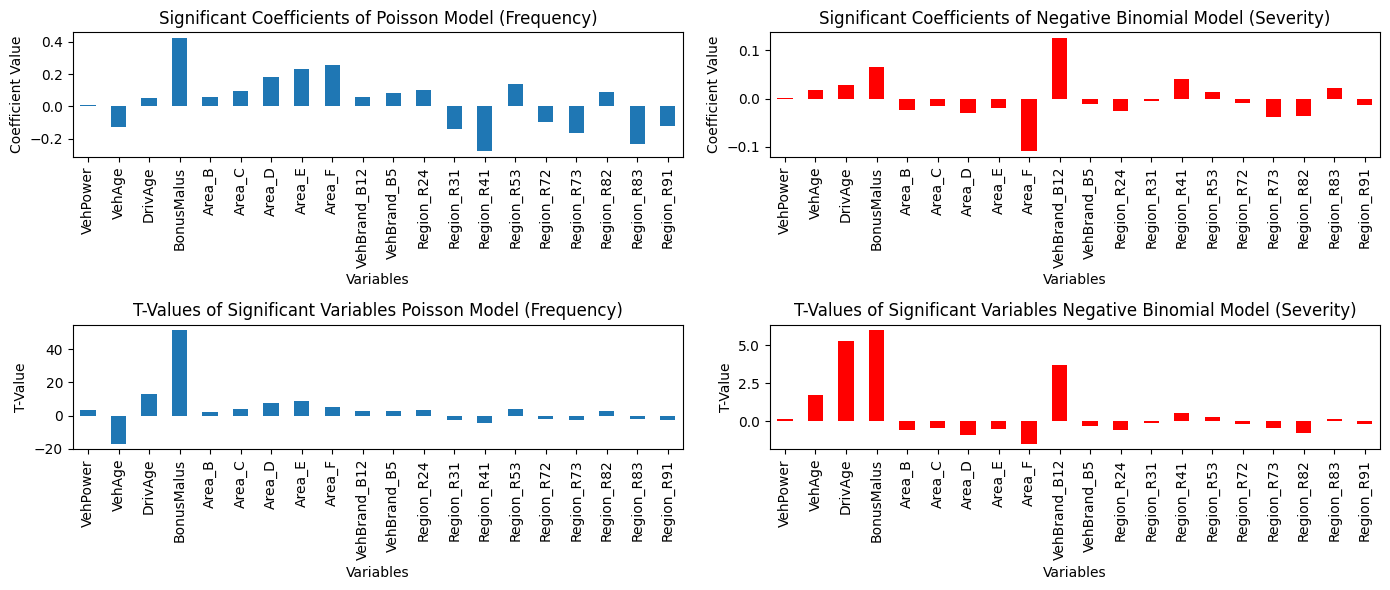

In [53]:
import matplotlib.pyplot as plt

# Set up the plotting area
fig, ax = plt.subplots(2, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot for Significant Coefficients
df_significant['Poisson_Coefficients'].plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('Significant Coefficients of Poisson Model (Frequency)')
ax[0,0].set_xlabel('Variables')
ax[0,0].set_ylabel('Coefficient Value')
#ax[0,0].legend('Poisson Coefficients')

df_significant['nbm_Coefficients'].plot(kind='bar',color='red', ax=ax[0,1])
ax[0,1].set_title('Significant Coefficients of Negative Binomial Model (Severity)')
#ax[0,1].set_title('T-Values of Significant Variables in  nbm Model')
ax[0,1].set_xlabel('Variables')
ax[0,1].set_ylabel('Coefficient Value')
#ax[0,1].legend( 'nbm Coefficients')

df_significant['Poisson_Tvalues'].plot(kind='bar', ax=ax[1,0])
ax[1,0].set_title('T-Values of Significant Variables Poisson Model (Frequency)')
ax[1,0].set_xlabel('Variables')
ax[1,0].set_ylabel('T-Value')
#ax[1,0].legend('Poisson Tvalues')

df_significant['nbm_Tvalues'].plot(kind='bar',color='red', ax=ax[1,1])
ax[1,1].set_title('T-Values of Significant Variables Negative Binomial Model (Severity)')
ax[1,1].set_xlabel('Variables')
ax[1,1].set_ylabel('T-Value')
#ax[1,1].legend('nbm Tvalues')

plt.tight_layout()
plt.show()
